### LOADING THE DATA

In [1]:
from pathlib import Path
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from floor_plan_class import FloorPlan

import utils.segment_geometry as sg
import utils.parse_geojson as pg


# Define the woring directory and filename
data_dir = Path("data", "clean")
filename = "Output5_clean.geojson"
segments, transform_parameters = pg.load_segments(data_dir / filename)

### THE LIST OF POINTS

In [2]:
# number of segments
n_segments = len(segments.geoms)
print('number of segments', n_segments)

number of segments 505


In [3]:
n_intermidiate_points = 20
##################################################
n_rows_df = 2 * len(segments.geoms)
df = {'x': [], 'y': []}
# add to think if possible to delete duplicated point without affecting the resulted plot
for segment in segments.geoms:
    df['x'].append(segment.xy[0][0])
    df['x'].append(segment.xy[0][1])

    df['y'].append(segment.xy[1][0])
    df['y'].append(segment.xy[1][1])

    # intermidiate points
    # x = np.linspace(segment.xy[0][0], segment.xy[0][0], n_intermidiate_points)
    # y = np.linspace(segment.xy[1][0], segment.xy[1][1], n_intermidiate_points)
    # df['x'].extend(x)
    # df['y'].extend(y)
    

df = pd.DataFrame.from_dict(df)

### PLOT

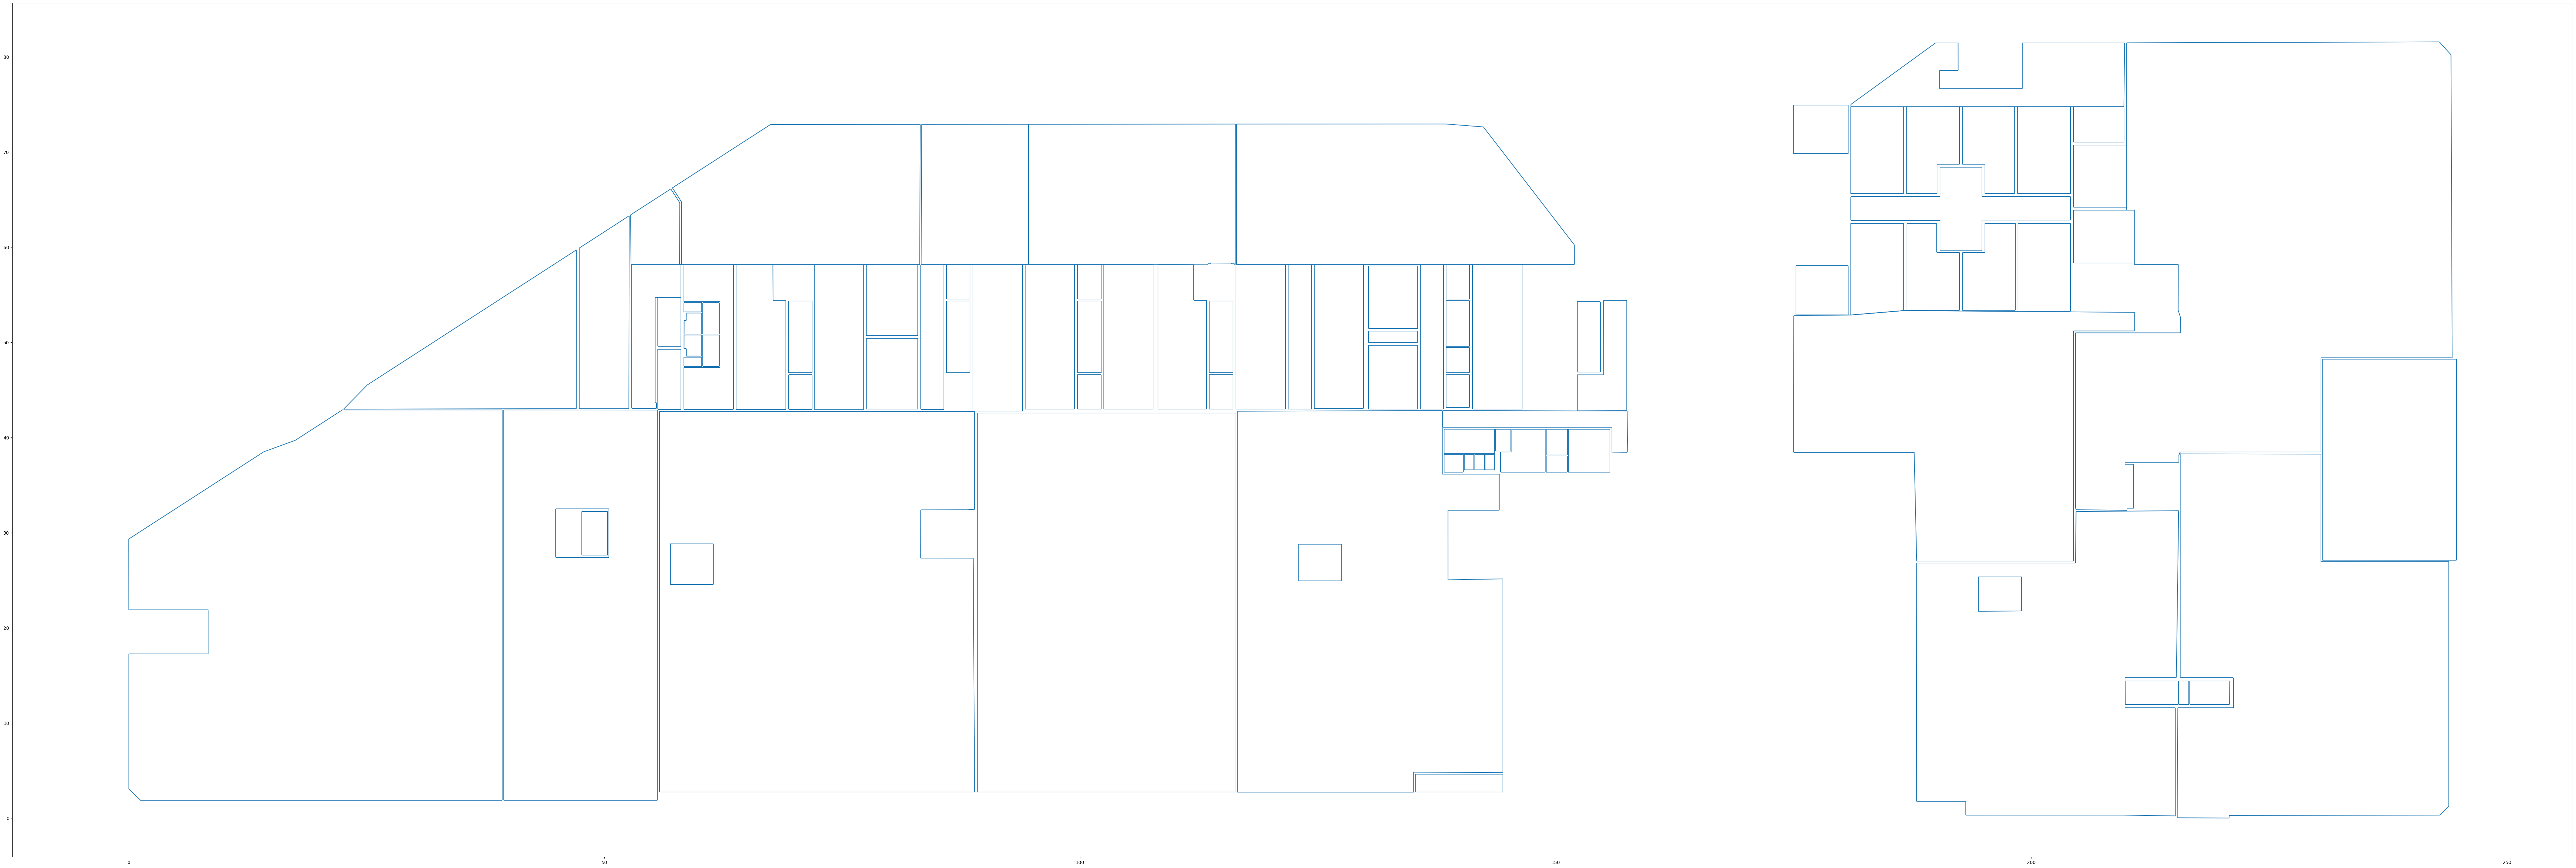

In [4]:
# H1: rise the definition
pg.plot_GeometryCollection(segments, figsize=(100, 100))

In [5]:
def color_map(cluster, n_clusters):
    """return a color for each cluster"""
    return plt.cm.viridis(cluster / n_clusters)

### CLUSTERING

In [6]:
# KMeans clustering
kmeans = KMeans(n_clusters=50)
kmeans.fit(df)

##################################################
# set cluster for each point
colors = []
for i in range(0, len(kmeans.labels_)):
    colors.append(color_map(kmeans.labels_[i], 50))

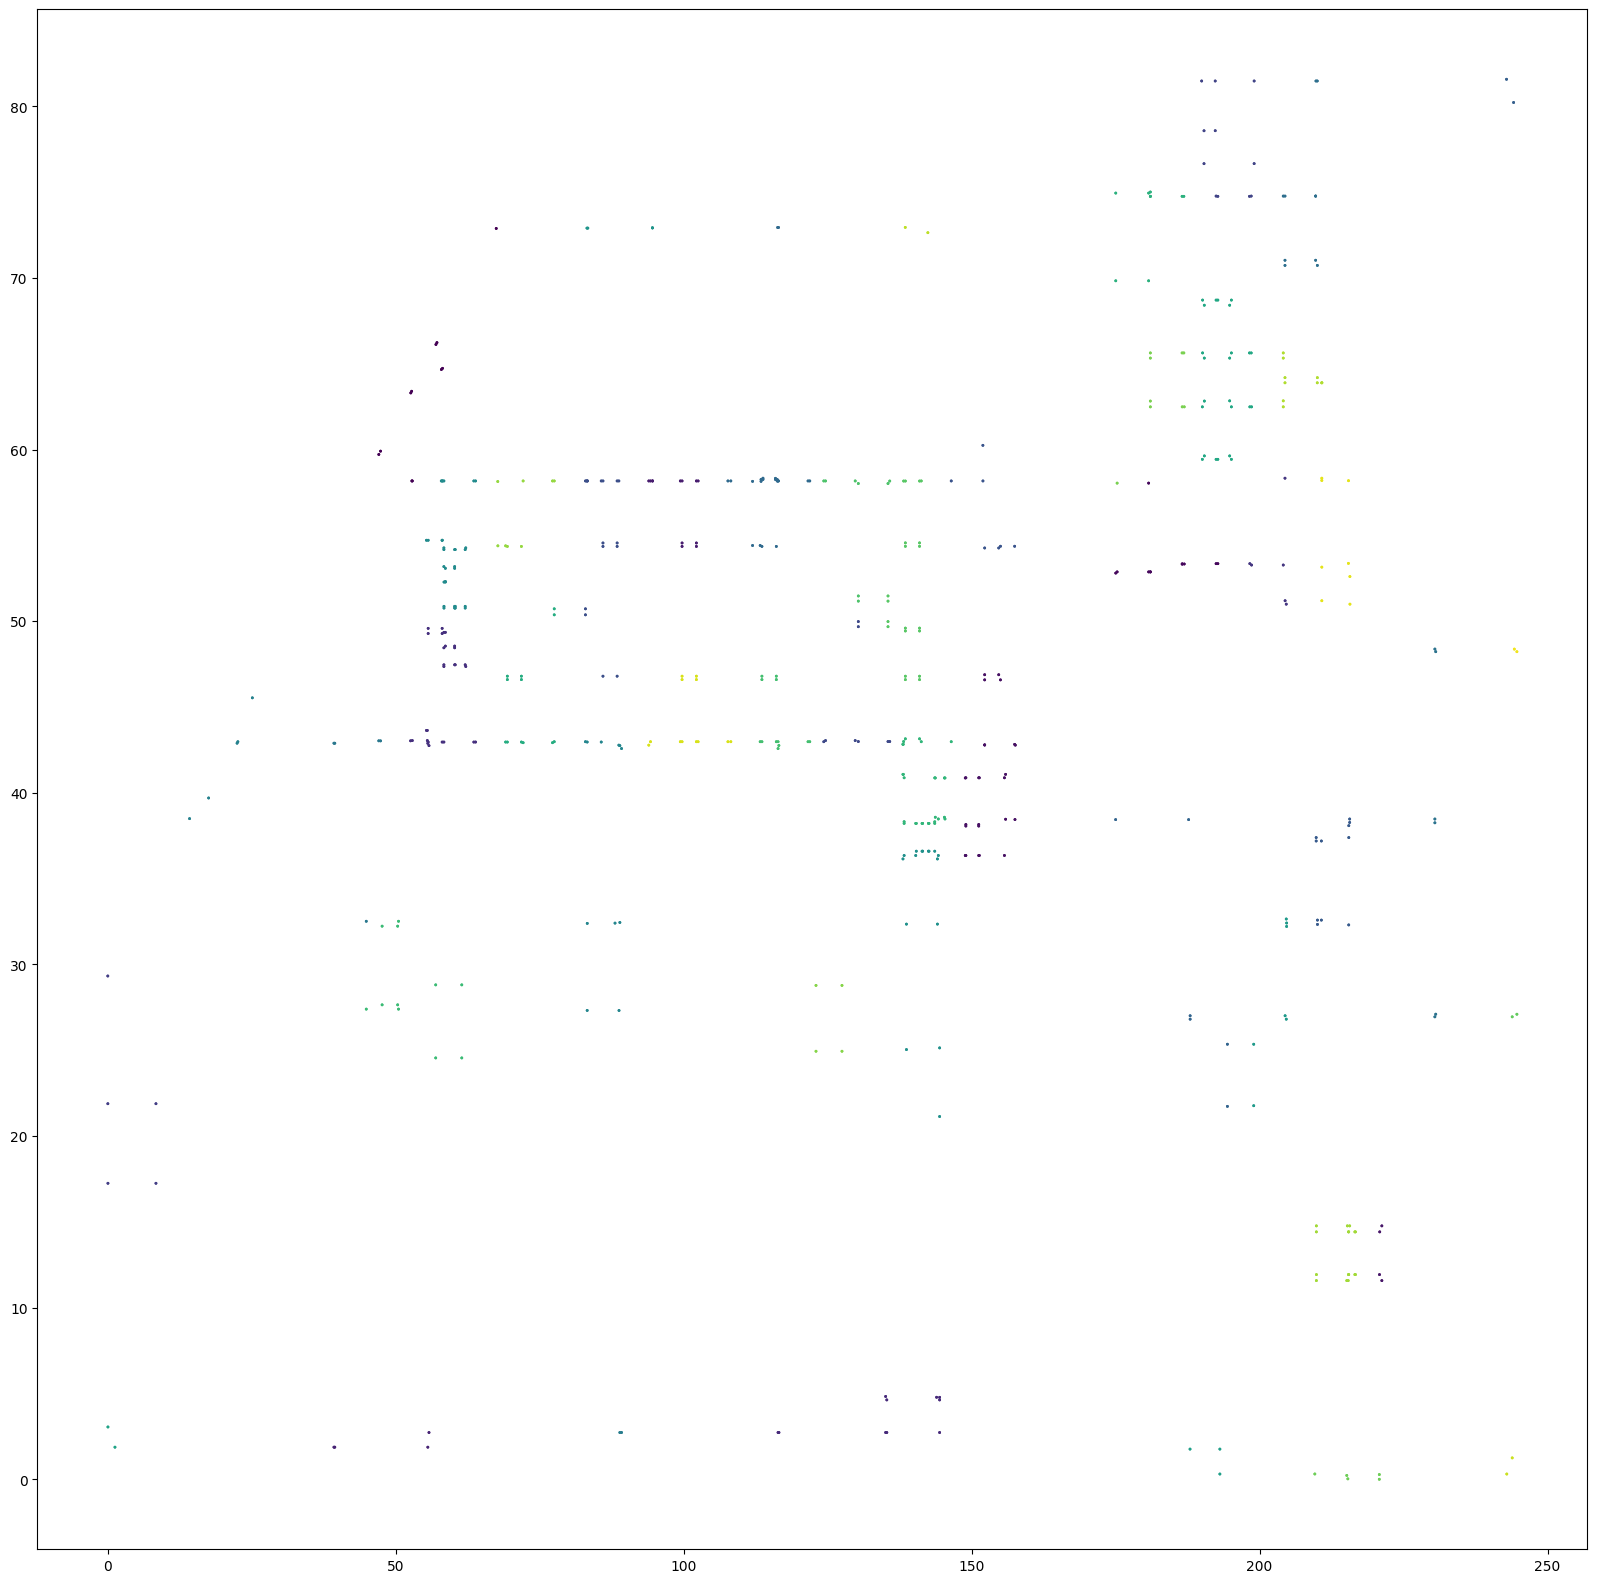

In [7]:
# plot points
plt.figure(figsize=(20, 20))
plt.scatter(df['x'], df['y'], c=colors, s=1)

In [8]:
# Nombre de points intermédiaires à ajouter pour chaque segment
n_intermidiate_points = 100

##################################################
# Création d'un dictionnaire pour stocker les coordonnées
df_dict = {'x': [], 'y': []}

# Pour chaque segment, on récupère les extrémités et on ajoute des points intermédiaires
for segment in segments.geoms:
    # Récupération des coordonnées des extrémités
    x_start, x_end = segment.xy[0][0], segment.xy[0][1]
    y_start, y_end = segment.xy[1][0], segment.xy[1][1]
    
    # Ajout des extrémités (optionnel si elles sont déjà incluses dans les points intermédiaires)
    df_dict['x'].append(x_start)
    df_dict['y'].append(y_start)
    df_dict['x'].append(x_end)
    df_dict['y'].append(y_end)
    
    # Génération et ajout des points intermédiaires
    # np.linspace génère n_intermidiate_points valeurs entre x_start et x_end, et pareil pour y
    x_intermediate = np.linspace(x_start, x_end, n_intermidiate_points)
    y_intermediate = np.linspace(y_start, y_end, n_intermidiate_points)
    
    # On ajoute tous les points intermédiaires
    df_dict['x'].extend(x_intermediate)
    df_dict['y'].extend(y_intermediate)

# Conversion du dictionnaire en DataFrame
df_intermediate_points = pd.DataFrame.from_dict(df_dict)

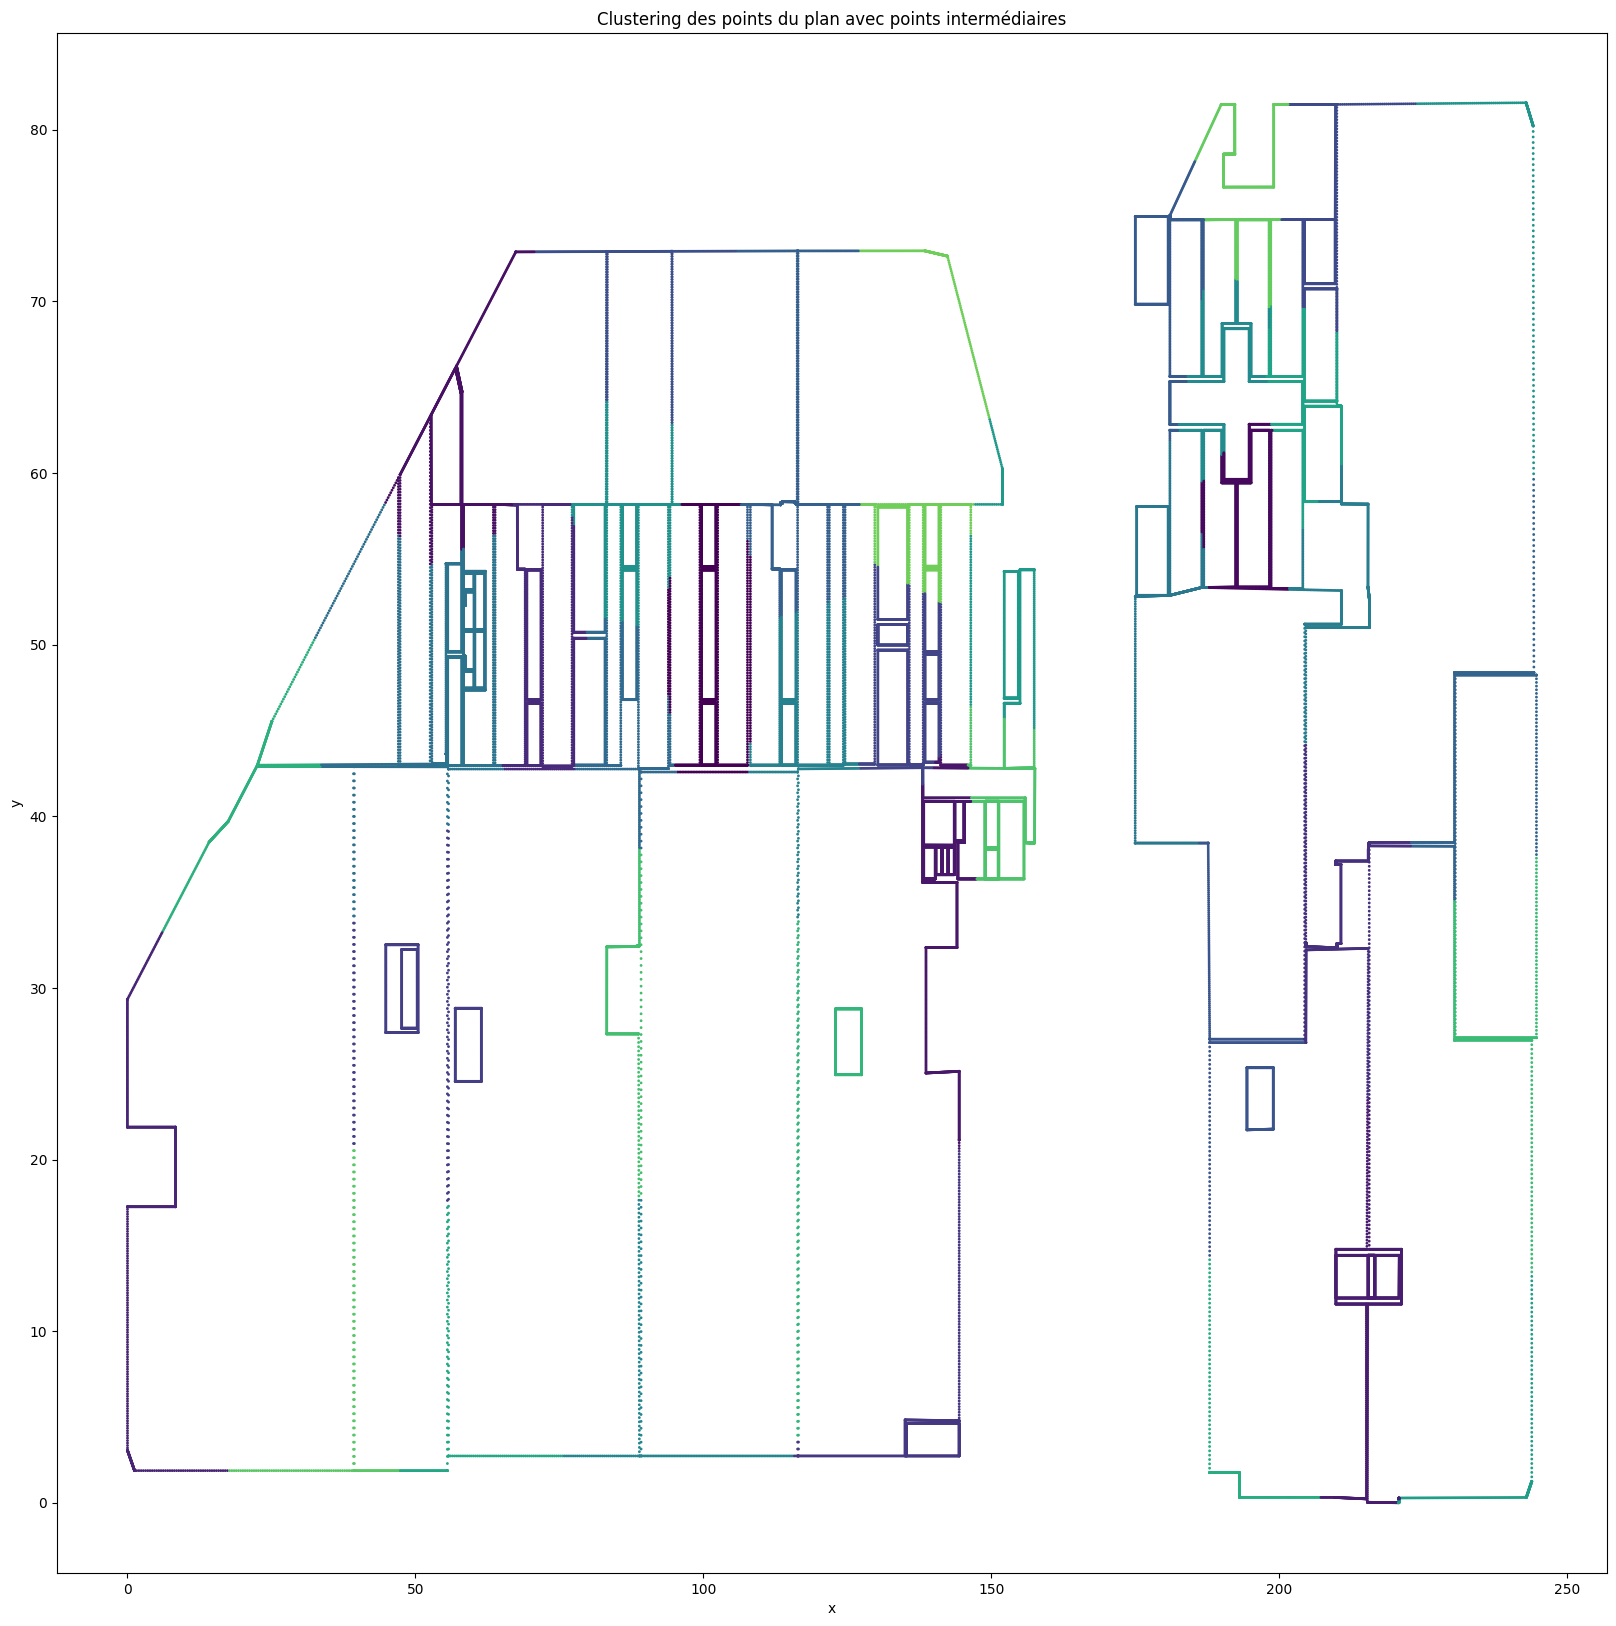

In [9]:
# Clustering avec KMeans
kmeans = KMeans(n_clusters=40, random_state=42)
kmeans.fit(df_intermediate_points)

##################################################
# Attribution d'une couleur à chaque point en fonction du cluster auquel il appartient
colors = []
for label in kmeans.labels_:
    colors.append(color_map(label, 50))

# Affichage du scatter plot des points clusterisés
plt.figure(figsize=(20, 20))
plt.scatter(df_intermediate_points['x'], df_intermediate_points['y'], c=colors, s=1)
plt.title("Clustering des points du plan avec points intermédiaires")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

DBSCAN a trouvé 394 clusters


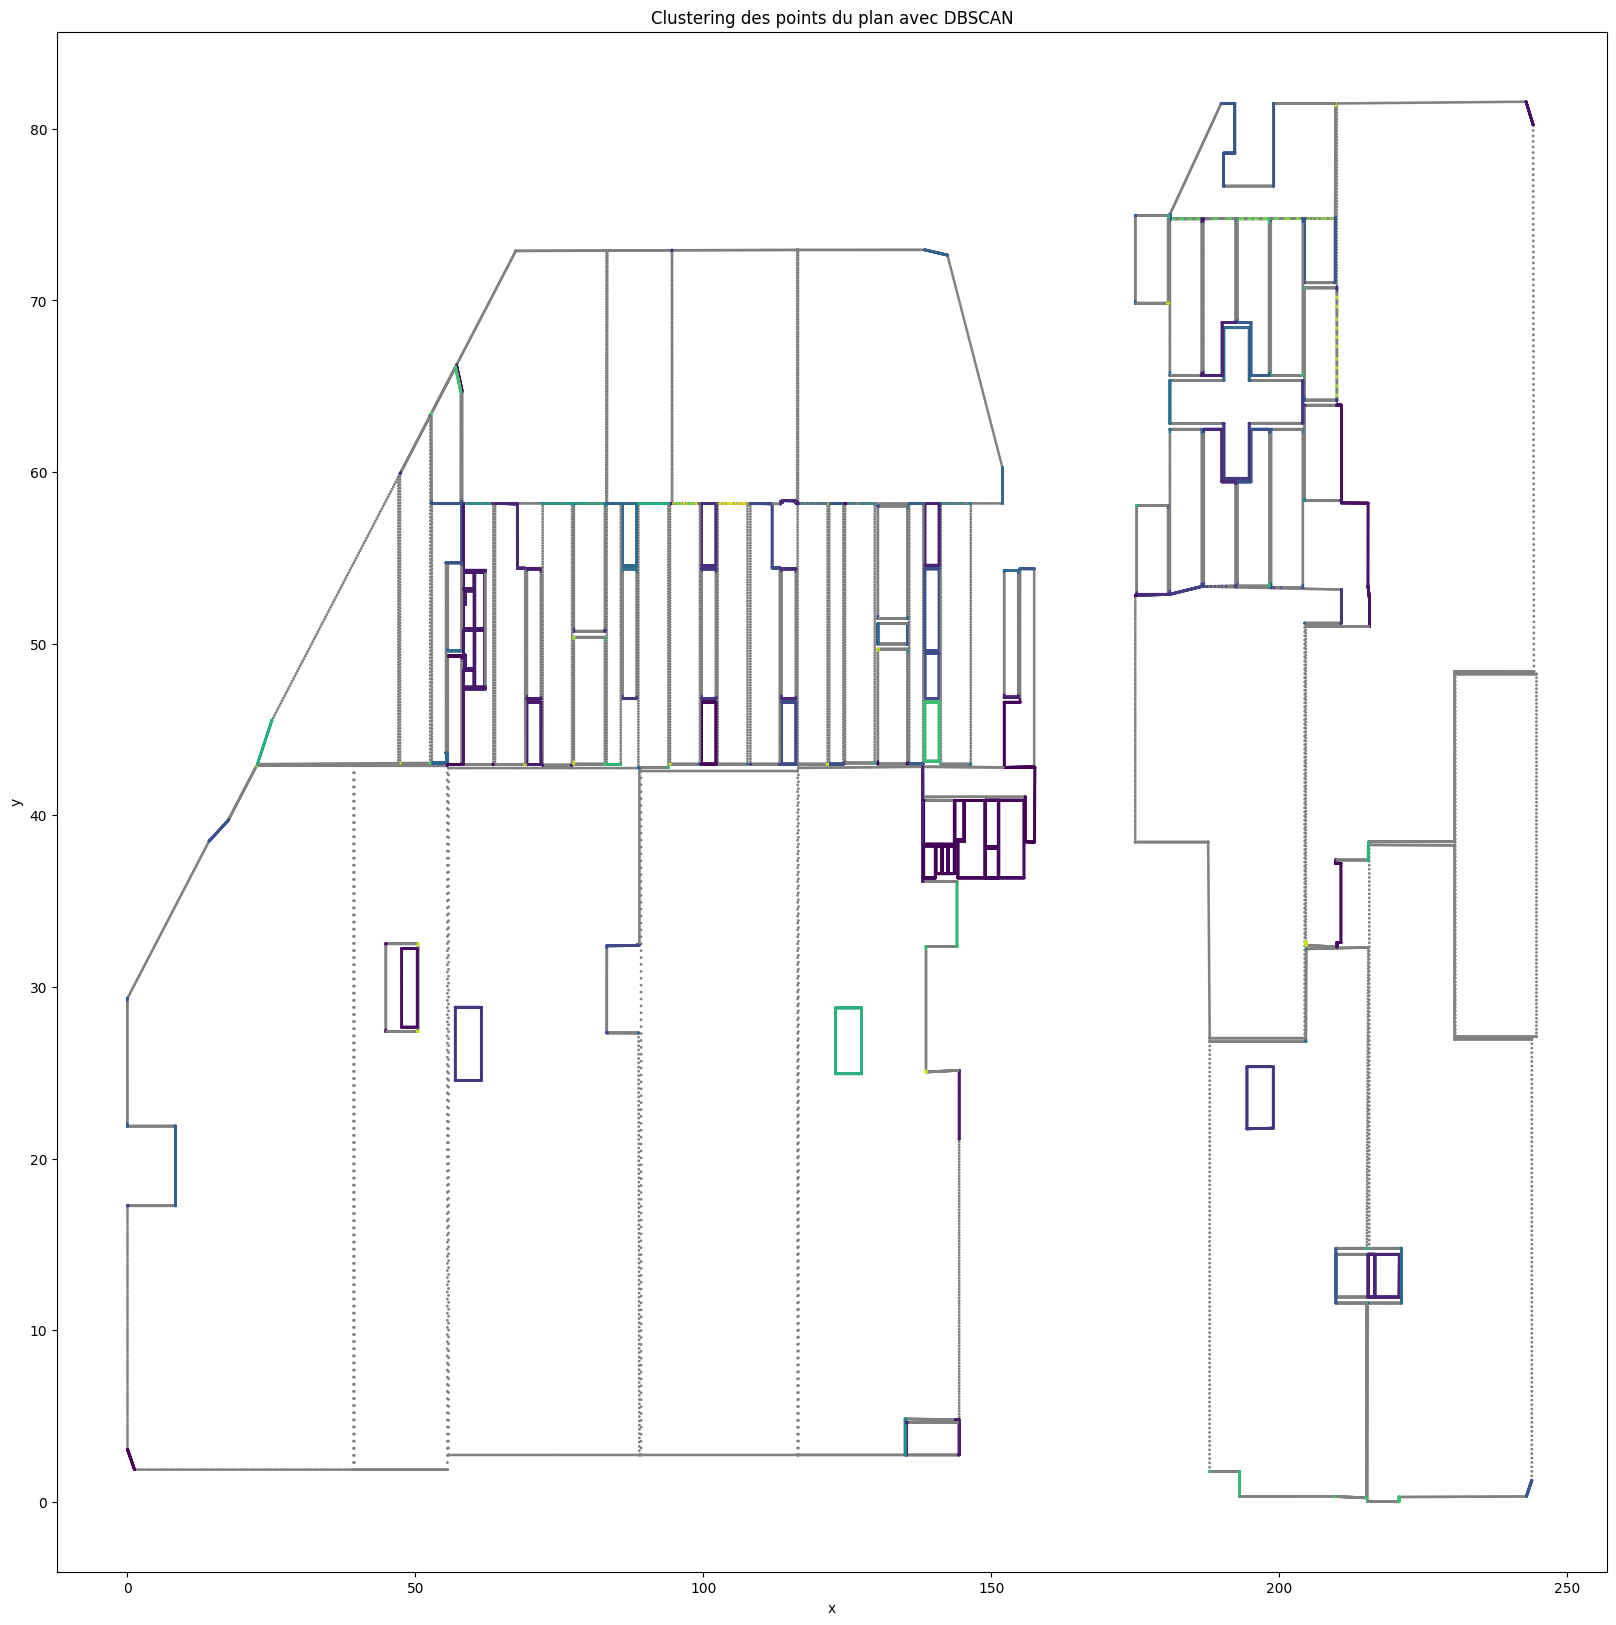

In [10]:
from sklearn.cluster import DBSCAN

# Paramètres de DBSCAN 
eps_value = 0.1     # Rayon de voisinage
min_samples_value = 5  # Nombre minimum de points dans le voisinage pour former un cluster

# Application de DBSCAN sur le DataFrame contenant les points intermédiaires
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan_labels = dbscan.fit_predict(df_intermediate_points)

# Calcul du nombre de clusters détectés (en excluant le bruit qui a pour label -1)
n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN a trouvé {n_clusters_db} clusters")

# Attribution d'une couleur à chaque point en fonction du cluster
colors_db = []
for label in dbscan_labels:
    if label == -1:
        # Points marqués comme bruit par DBSCAN, on leur assigne une couleur grise
        colors_db.append("gray")
    else:
        # On normalise la valeur du label pour l'utiliser avec la colormap viridis
        colors_db.append(plt.cm.viridis(label / n_clusters_db))

# Affichage du scatter plot avec DBSCAN
plt.figure(figsize=(20, 20))
plt.scatter(df_intermediate_points['x'], df_intermediate_points['y'], c=colors_db, s=1)
plt.title("Clustering des points du plan avec DBSCAN")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

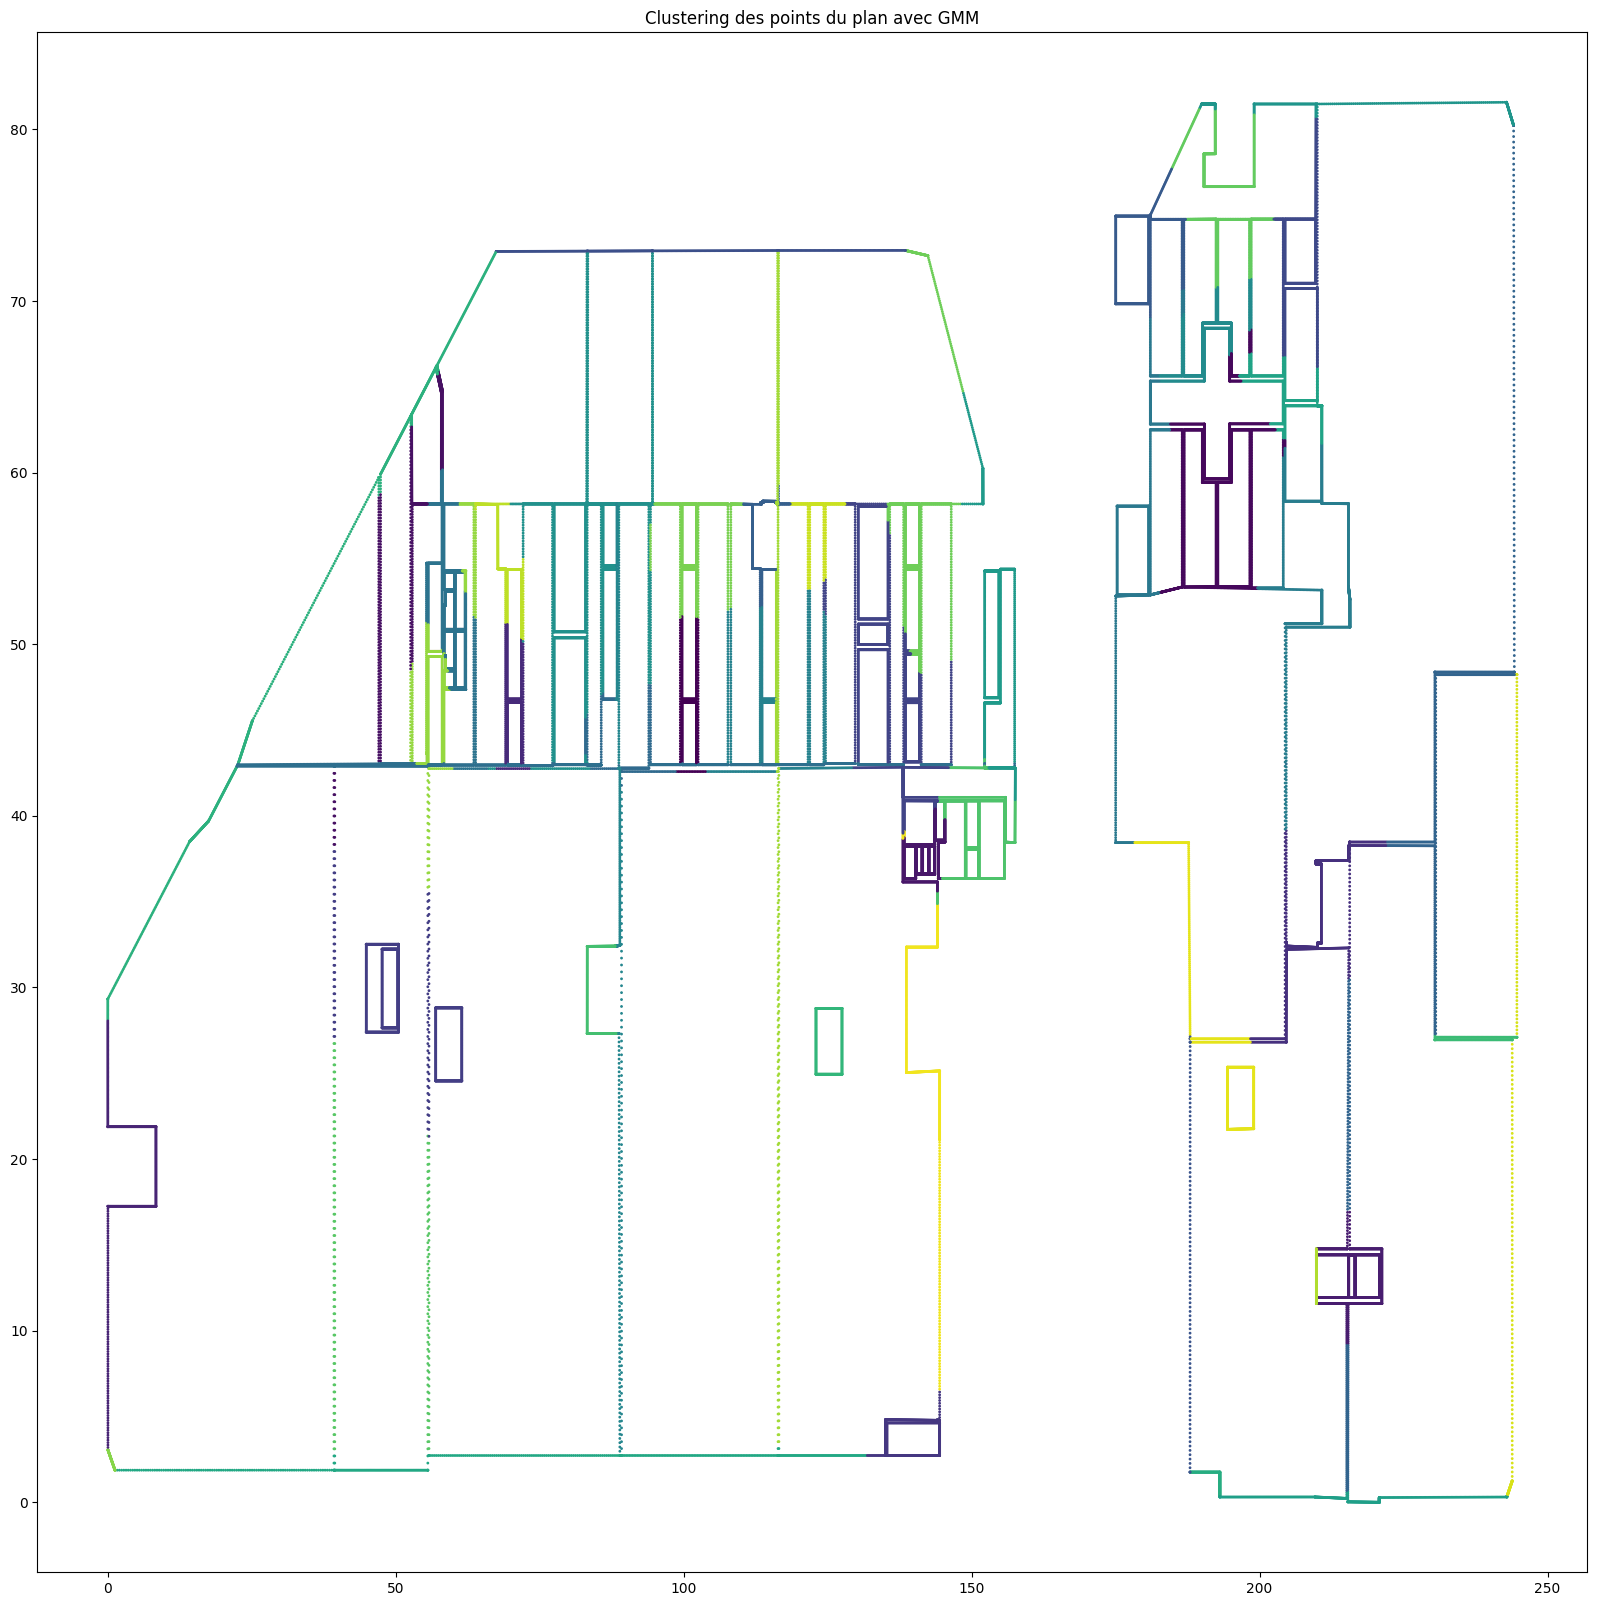

In [11]:
from sklearn.mixture import GaussianMixture

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=50, random_state=42)
gmm_labels = gmm.fit_predict(df_intermediate_points)

# Visualisation
colors_gmm = [plt.cm.viridis(label / 50) for label in gmm_labels]
plt.figure(figsize=(20, 20))
plt.scatter(df_intermediate_points['x'], df_intermediate_points['y'], c=colors_gmm, s=1)
plt.title("Clustering des points du plan avec GMM")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN a trouvé 578 clusters


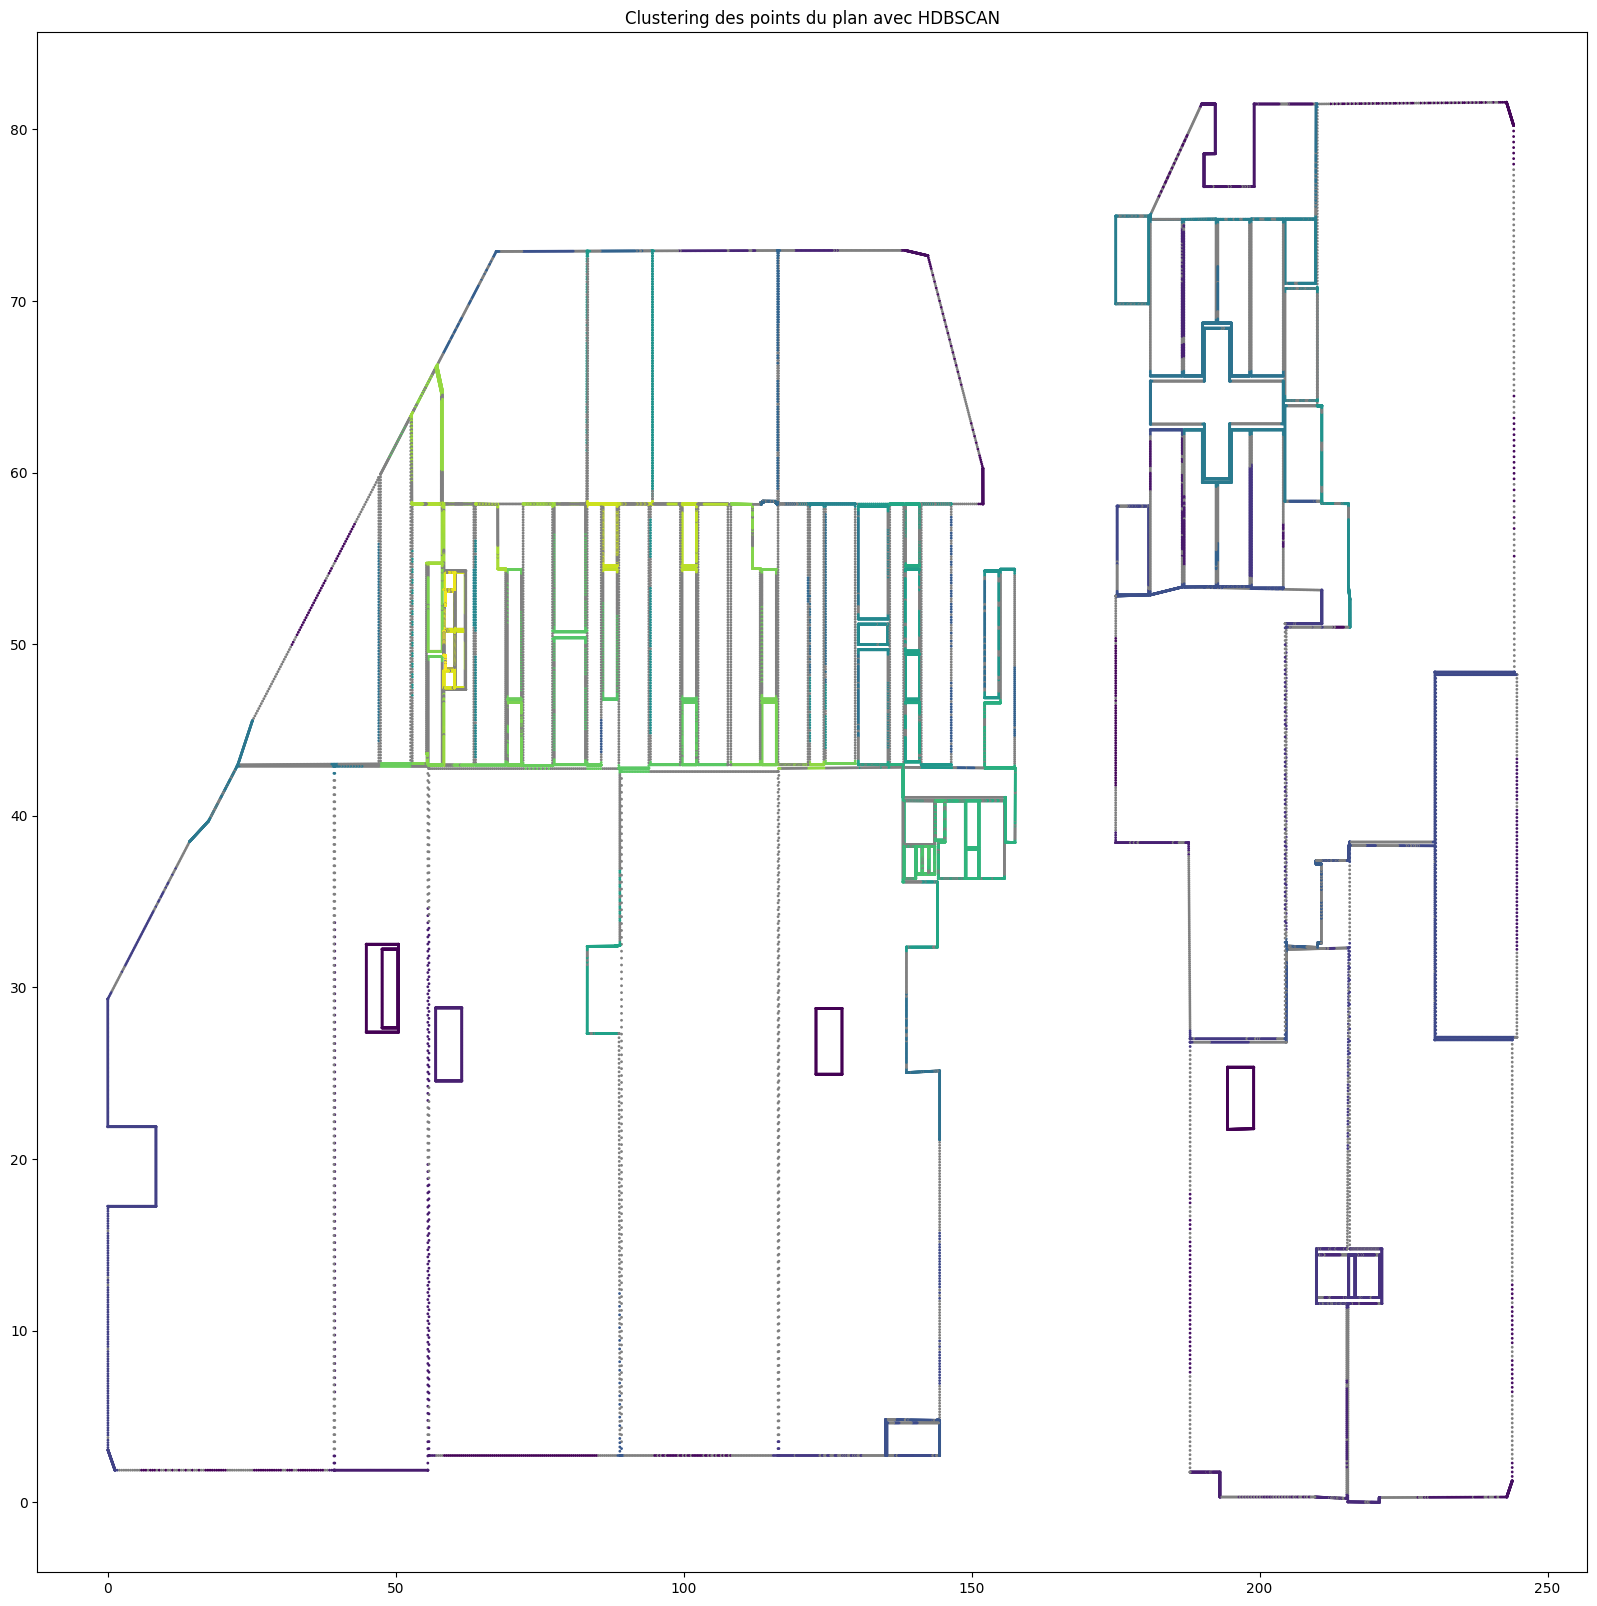

In [12]:
import hdbscan

# HDBSCAN clustering
hdb = hdbscan.HDBSCAN(min_cluster_size=10)  # Ajustez min_cluster_size selon vos données
hdb_labels = hdb.fit_predict(df_intermediate_points)

# Calcul du nombre de clusters détectés (en excluant le bruit qui a pour label -1)
n_clusters_hdb = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
print(f"HDBSCAN a trouvé {n_clusters_hdb} clusters")

# Visualisation
colors_hdb = ["gray" if label == -1 else plt.cm.viridis(label / n_clusters_hdb) for label in hdb_labels]
plt.figure(figsize=(20, 20))
plt.scatter(df_intermediate_points['x'], df_intermediate_points['y'], c=colors_hdb, s=1)
plt.title("Clustering des points du plan avec HDBSCAN")
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=50)  # Ajustez n_clusters selon vos besoins
agglo_labels = agglo.fit_predict(df_intermediate_points)

# Visualisation
colors_agglo = [plt.cm.viridis(label / 50) for label in agglo_labels]
plt.figure(figsize=(20, 20))
plt.scatter(df_intermediate_points['x'], df_intermediate_points['y'], c=colors_agglo, s=1)
plt.title("Clustering des points du plan avec Agglomerative Clustering")
plt.show()

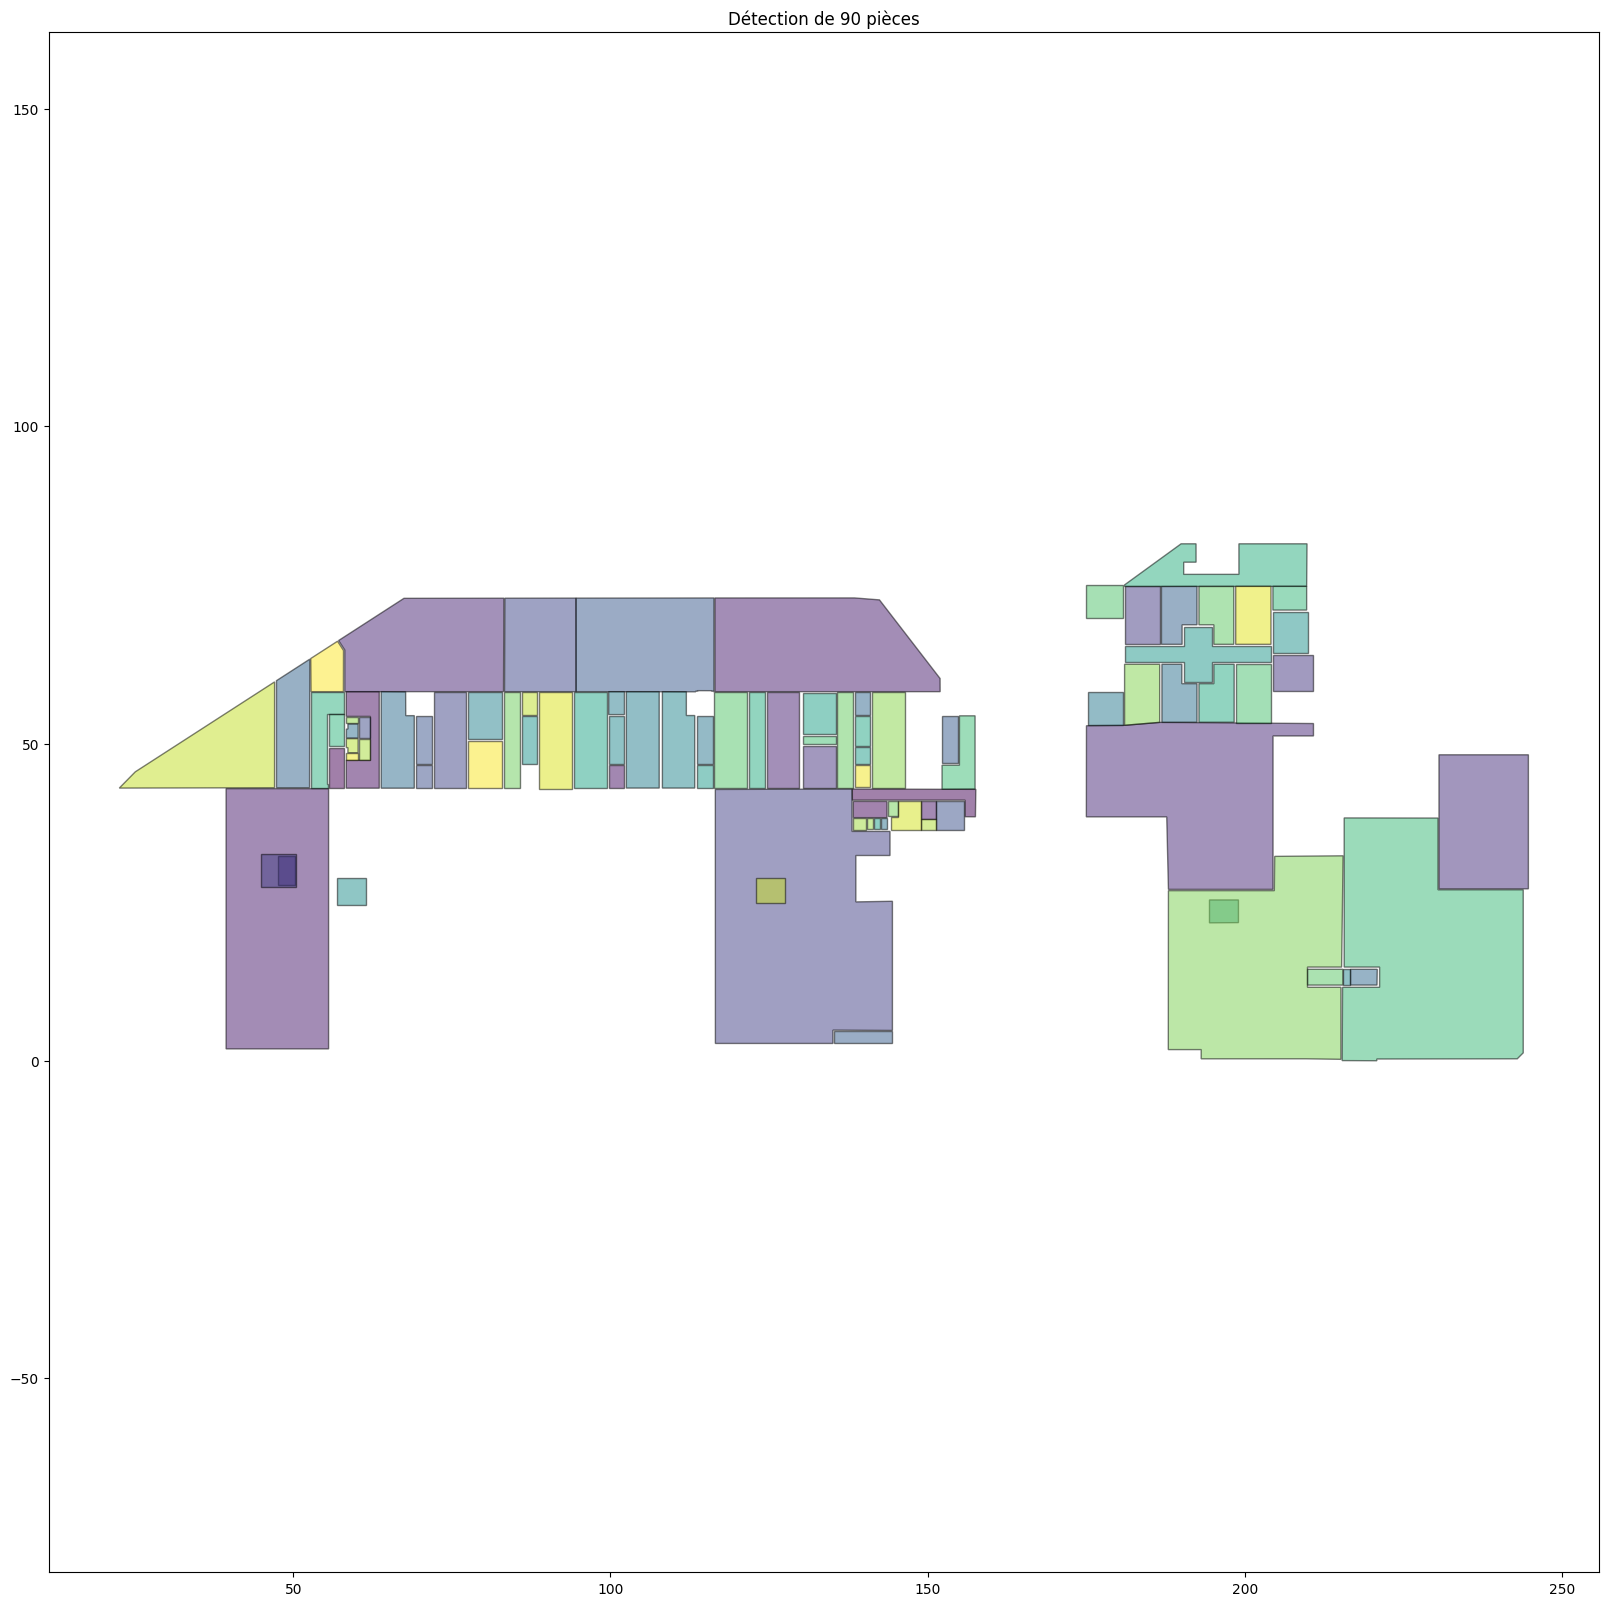

In [13]:
import numpy as np
from shapely.geometry import LineString, Polygon, MultiPolygon
from shapely.ops import unary_union, polygonize
import matplotlib.pyplot as plt

class SegmentBasedClustering:
    def __init__(self, segments):
        self.segments = segments
        self.rooms = None
    
    def find_closed_paths(self):
        """Identifie les chemins fermés formés par les segments"""
        lines = unary_union(self.segments)
        potential_rooms = list(polygonize(lines))
        
        # Convertir les MultiPolygon en liste de Polygon
        processed_rooms = []
        for room in potential_rooms:
            if isinstance(room, MultiPolygon):
                processed_rooms.extend(list(room.geoms))
            else:
                processed_rooms.append(room)
                
        return processed_rooms
    
    def filter_rooms(self, min_area=1.0, max_area=1000.0):
        """Filtre les polygones selon des critères de taille"""
        valid_rooms = []
        for room in self.rooms:
            area = room.area
            if min_area <= area <= max_area:
                valid_rooms.append(room)
        return valid_rooms
    
    def find_adjacent_rooms(self):
        """Identifie les pièces adjacentes"""
        n_rooms = len(self.rooms)
        adjacency_matrix = np.zeros((n_rooms, n_rooms), dtype=bool)
        
        for i in range(n_rooms):
            for j in range(i + 1, n_rooms):
                if self.rooms[i].touches(self.rooms[j]):
                    adjacency_matrix[i, j] = adjacency_matrix[j, i] = True
        
        return adjacency_matrix
    
    def merge_small_rooms(self, min_area=5.0):
        """Fusionne les petites pièces avec leurs voisines"""
        modified = True
        while modified:
            modified = False
            
            # Identification des petites pièces
            small_rooms = []
            for i, room in enumerate(self.rooms):
                if room.area < min_area:
                    small_rooms.append(i)
            
            if not small_rooms:
                break
                
            adjacency = self.find_adjacent_rooms()
            
            # Traitement de chaque petite pièce
            for small_room_idx in small_rooms:
                if small_room_idx >= len(self.rooms):
                    continue
                    
                neighbors = [i for i in range(len(self.rooms)) 
                           if i != small_room_idx and adjacency[small_room_idx][i]]
                
                if not neighbors:
                    continue
                
                best_neighbor = max(neighbors, 
                                  key=lambda x: self.rooms[x].area if x < len(self.rooms) else 0)
                
                if best_neighbor >= len(self.rooms):
                    continue
                
                # Fusionne les pièces
                merged = unary_union([
                    self.rooms[best_neighbor],
                    self.rooms[small_room_idx]
                ])
                
                # Traite le cas où la fusion produit un MultiPolygon
                if isinstance(merged, MultiPolygon):
                    largest_poly = max(merged.geoms, key=lambda p: p.area)
                    merged = largest_poly
                
                # Met à jour la liste des pièces
                new_rooms = []
                for i in range(len(self.rooms)):
                    if i == best_neighbor:
                        new_rooms.append(merged)
                    elif i != small_room_idx:
                        new_rooms.append(self.rooms[i])
                
                self.rooms = new_rooms
                modified = True
                break
    
    def fit(self, min_room_area=1.0, max_room_area=1000.0):
        """Exécute l'algorithme complet de détection des pièces"""
        self.rooms = self.find_closed_paths()
        
        if not self.rooms:
            print("Aucune pièce fermée n'a été trouvée")
            return []
        
        self.rooms = self.filter_rooms(min_room_area, max_room_area)
        
        if not self.rooms:
            print("Aucune pièce ne correspond aux critères de taille")
            return []
        
        self.merge_small_rooms()
        return self.rooms

def plot_rooms(rooms, figsize=(20, 20)):
    """Visualise les pièces détectées"""
    if not rooms:
        print("Pas de pièces à afficher")
        return
        
    plt.figure(figsize=figsize)
    
    n_rooms = len(rooms)
    colors = plt.cm.viridis(np.linspace(0, 1, n_rooms))
    
    for room, color in zip(rooms, colors):
        # Gestion des MultiPolygon
        if isinstance(room, MultiPolygon):
            for polygon in room.geoms:
                x, y = polygon.exterior.xy
                plt.fill(x, y, alpha=0.5, fc=color, ec='black')
        else:
            x, y = room.exterior.xy
            plt.fill(x, y, alpha=0.5, fc=color, ec='black')
    
    plt.axis('equal')
    plt.title(f"Détection de {n_rooms} pièces")
    plt.show()
    
    
clusterer = SegmentBasedClustering(segments)
rooms = clusterer.fit()

# Visualisation des résultats
plot_rooms(rooms)